Author: [Louis Owen](https://louisowen6.github.io/)

This is the accompanying notebook of the article "[xxx](...)" published at Bukalapak Data Medium Page.

This notebook contains the tutorial of performing **Anomaly Detection on Time Series Data** by using various techniques starting from **Static Thresholding**, **Dynamic Thresholding**, until utilizing Machine Learning-based model, **Isolation Forest**.

The data used in this tutorial is a **generated dummy data about historical credits top-up at the e-commerce company**. Each row represents the aggregation value within **30-minutes interval**.

# Environment Setup

In [1]:
!pip install scikit-learn==0.23.2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import ParameterSampler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

In [3]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

1.2.4
1.17.2
0.11.1


In [4]:
%cd gcs/louis.owen/Medium Articles/Anomaly Detection

/gcs/louis.owen/Medium Articles/Anomaly Detection


# Function Definition

In [5]:
def performance_report(data):
    '''Function to generate performance report of the predicted anomaly event
    '''
    num_pred_positive = len(data[(data['label']==True)])
    
    if num_pred_positive == 0:
        return None
    else:
        num_positive = len(data[(data['anomaly']==True)])

        precision = len(data[(data['label']==True) & (data['anomaly']==True)])/num_pred_positive
        recall = len(data[(data['label']==True) & (data['anomaly']==True)])/num_positive

        if (precision==0) or (recall==0):
            return None
        else:
            f1 = 2*precision*recall/(precision+recall)

            return {'precision':precision,'recall':recall,'f1':f1}

        
def convert_to_non_consecutive_trigger(pred_date_series):
    '''Function to get the first trigger of consecutive predicted anomaly event
    '''
    non_consecutive_index = [0]
    for i in range(1,len(pred_date_series)):
        if ((pred_date_series.iloc[i] - pred_date_series.iloc[i-1]).seconds != 300*6):
            non_consecutive_index.append(i)
    non_consecutive_dates = [pred_date_series.iloc[i] for i in non_consecutive_index]
    return pd.Series(non_consecutive_dates)

# Data ELT 

In [6]:
df = pd.read_csv('dummy_topup_data.csv')
df

,datetime,sum_amount,avg_amount_per_user,anomaly
0,2017-05-16 00:10:00,26.323942,16.474923,False
1,2017-05-16 00:40:00,25.363050,15.325484,False
2,2017-05-16 01:10:00,25.443192,11.128038,False
3,2017-05-16 01:40:00,26.149407,10.833380,False
4,2017-05-16 02:10:00,25.801580,10.858455,False
...,...,...,...,...
12269,2018-01-26 14:40:00,26.103956,13.934151,False
12270,2018-01-26 15:10:00,26.499405,14.409160,False
12271,2018-01-26 15:40:00,26.380532,14.416234,False
12272,2018-01-26 16:10:00,26.207231,14.174578,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12274 entries, 0 to 12273
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             12274 non-null  object 
 1   sum_amount           12274 non-null  float64
 2   avg_amount_per_user  12274 non-null  float64
 3   anomaly              12274 non-null  bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 299.8+ KB


Convert `datetime` column to pandas.datetime dtype and setting it as the index of the dataframe

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

Apart from using the original features, we'll also generate some other features such as moving average and rolling z-score both from the sum and average column.

In [9]:
# Moving Average
df['sum_amount_ma_5'] = df['sum_amount'].rolling(5).mean().ffill().bfill()
df['avg_amount_per_user_ma_5'] = df['avg_amount_per_user'].rolling(5).mean().ffill().bfill()

# Rolling z-score (basically by performing standardization on the rolling window)
df['sum_amount_zscore_10'] = ((df['sum_amount'] - df['sum_amount'].rolling(10).mean())/
                              df['sum_amount'].rolling(10).std()).ffill().bfill()
df['avg_amount_per_user_zscore_10'] = ((df['avg_amount_per_user'] - df['avg_amount_per_user'].rolling(10).mean())/
                                       df['avg_amount_per_user'].rolling(10).std()).ffill().bfill()

Now, the final version of the transformed data is ready to be used.

In [10]:
df

,sum_amount,avg_amount_per_user,anomaly,sum_amount_ma_5,avg_amount_per_user_ma_5,sum_amount_zscore_10,avg_amount_per_user_zscore_10
datetime,,,,,,,
2017-05-16 00:10:00,26.323942,16.474923,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 00:40:00,25.363050,15.325484,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 01:10:00,25.443192,11.128038,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 01:40:00,26.149407,10.833380,False,25.816234,12.924056,0.370560,0.036218
2017-05-16 02:10:00,25.801580,10.858455,False,25.816234,12.924056,0.370560,0.036218
...,...,...,...,...,...,...,...
2018-01-26 14:40:00,26.103956,13.934151,False,26.931094,14.584182,-1.522015,-1.270594
2018-01-26 15:10:00,26.499405,14.409160,False,26.912292,14.642117,-0.865601,-0.429957
2018-01-26 15:40:00,26.380532,14.416234,False,26.544841,14.375585,-0.856319,-0.390570


# EDA

## Anomaly Event Distribution

As can be seen, the number of the anomaly event groundtruth is **less than 0.5%** from the total data.

In [11]:
100 * df['anomaly'].value_counts(True)

False    99.665961
True      0.334039
Name: anomaly, dtype: float64

In [12]:
list(df[df['anomaly']==True].index)

[Timestamp('2017-09-25 04:40:00'),
 Timestamp('2017-09-25 05:10:00'),
 Timestamp('2017-11-12 01:40:00'),
 Timestamp('2017-11-12 08:40:00'),
 Timestamp('2017-11-12 09:10:00'),
 Timestamp('2017-11-12 09:40:00'),
 Timestamp('2017-11-12 10:10:00'),
 Timestamp('2017-11-12 10:40:00'),
 Timestamp('2017-11-12 11:10:00'),
 Timestamp('2017-11-12 11:40:00'),
 Timestamp('2017-11-12 12:10:00'),
 Timestamp('2017-11-12 12:40:00'),
 Timestamp('2017-11-12 13:10:00'),
 Timestamp('2017-11-12 13:40:00'),
 Timestamp('2018-01-03 00:10:00'),
 Timestamp('2018-01-03 00:40:00'),
 Timestamp('2018-01-03 01:10:00'),
 Timestamp('2018-01-03 01:40:00'),
 Timestamp('2018-01-03 02:10:00'),
 Timestamp('2018-01-03 02:40:00'),
 Timestamp('2018-01-03 03:10:00'),
 Timestamp('2018-01-03 03:40:00'),
 Timestamp('2018-01-03 04:10:00'),
 Timestamp('2018-01-03 04:40:00'),
 Timestamp('2018-01-03 05:10:00'),
 Timestamp('2018-01-03 05:40:00'),
 Timestamp('2018-01-03 06:10:00'),
 Timestamp('2018-01-03 06:40:00'),
 Timestamp('2018-01-

## Sum Amount

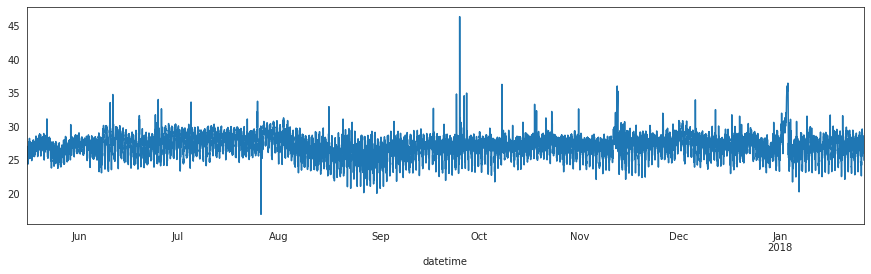

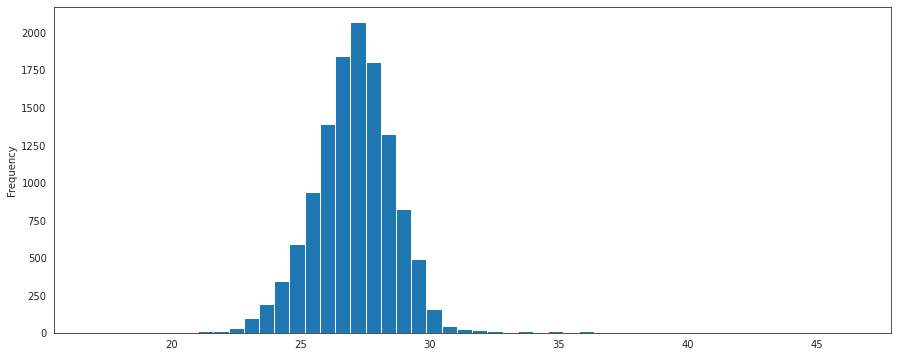

In [13]:
df['sum_amount'].plot(figsize=(15,4))
plt.show()

df['sum_amount'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

## Moving Average of Sum Amount

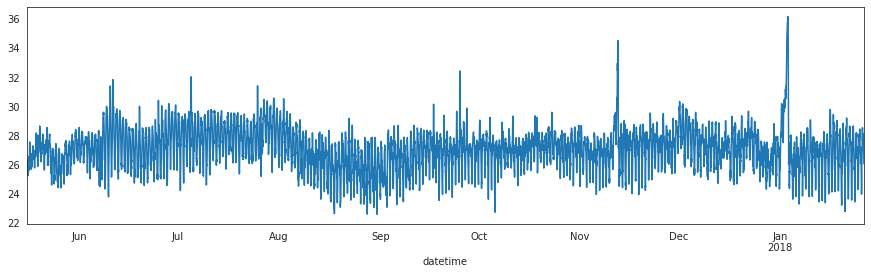

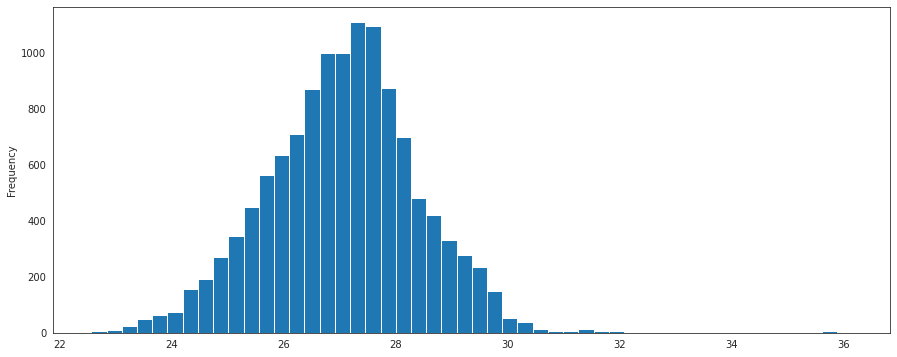

In [14]:
df['sum_amount_ma_5'].plot(figsize=(15,4))
plt.show()

df['sum_amount_ma_5'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

## Rolling Z-Score of Sum Amount

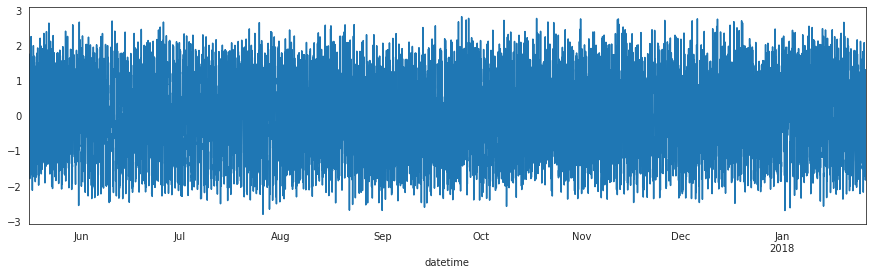

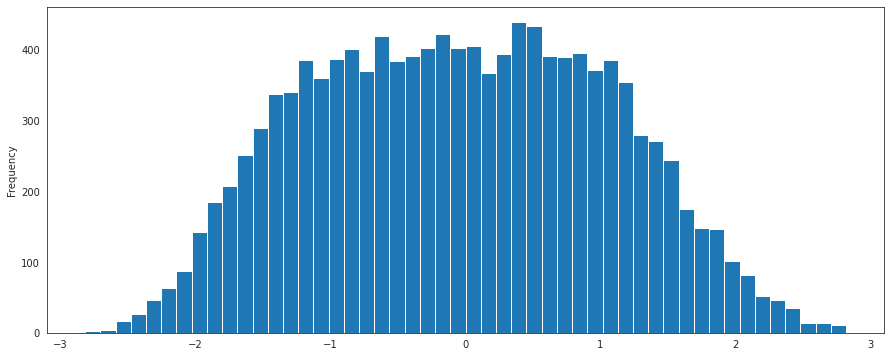

In [15]:
df['sum_amount_zscore_10'].plot(figsize=(15,4))
plt.show()

df['sum_amount_zscore_10'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

## Average Amount per User

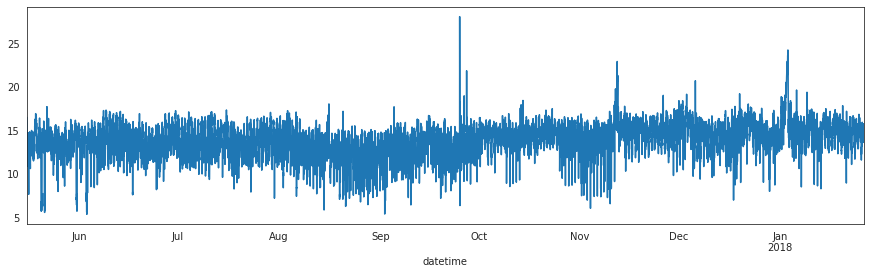

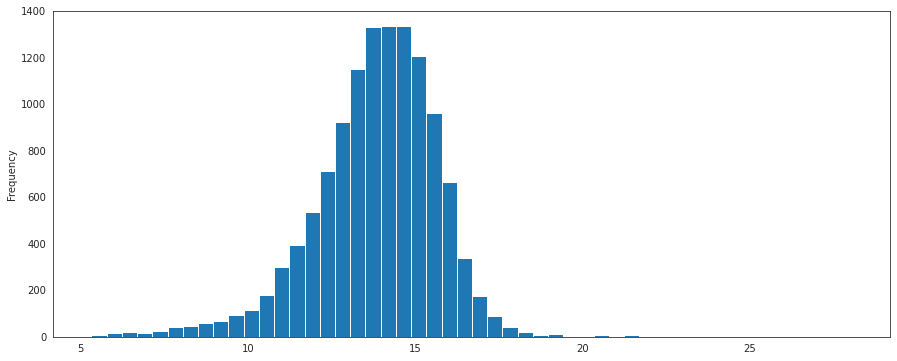

In [16]:
df['avg_amount_per_user'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

## Moving Average of Average Amount per User

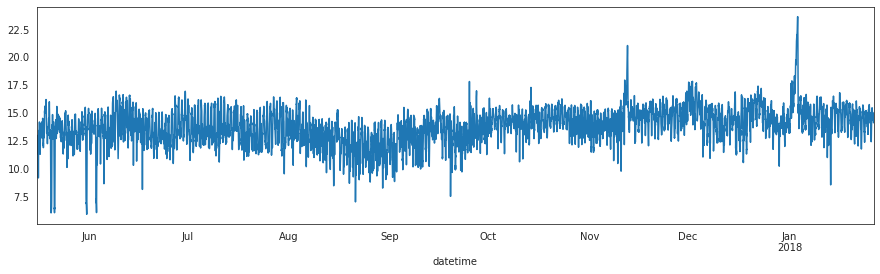

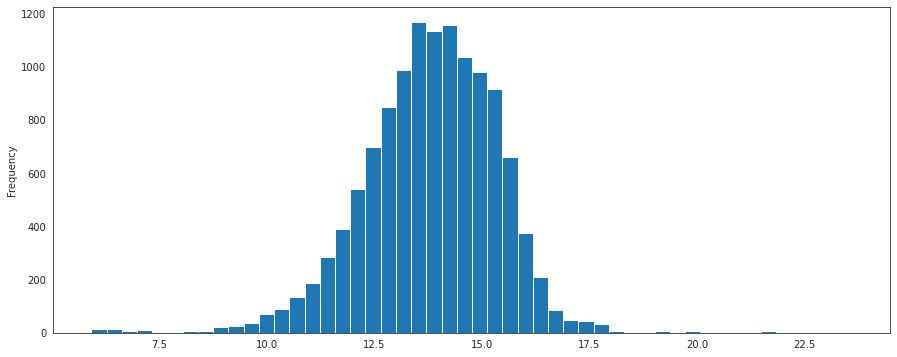

In [17]:
df['avg_amount_per_user_ma_5'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user_ma_5'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

## Rolling Z-Score of Average Amount per User

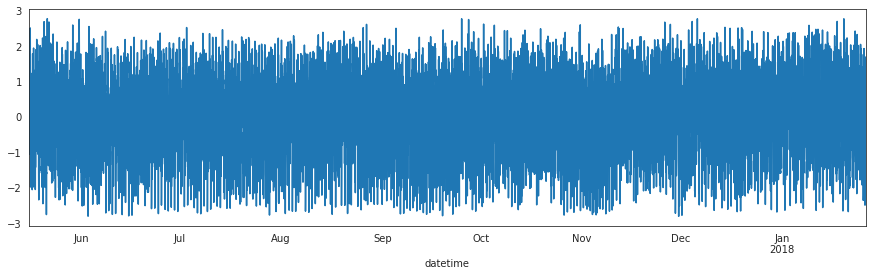

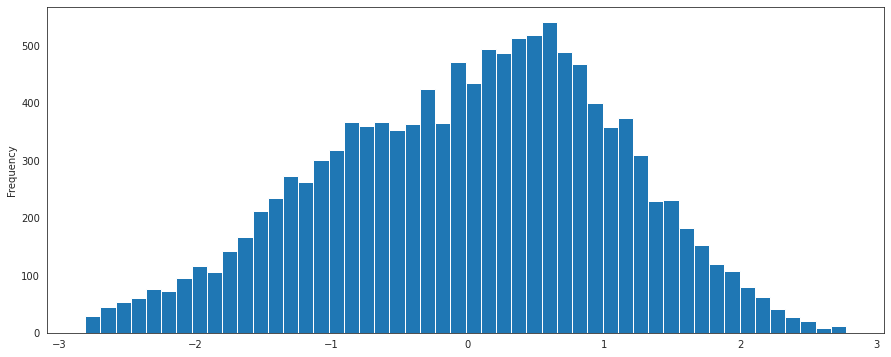

In [18]:
df['avg_amount_per_user_zscore_10'].plot(figsize=(15,4))
plt.show()

df['avg_amount_per_user_zscore_10'].plot(figsize=(15,6),kind='hist',bins=50)
plt.show()

# Anomaly Detection Experiment

We will experiment with 3 types of anomaly detection techniques:
- Static Thresholding
- Dynamic Thresholding
- Isolation Forest

Since we need to choose the most appropriate parameters for each of the techniques, we have to utilize one of many optimization algorithms available out there to help us find the best parameters.

In this experiment, we will use **Random Search** optimization algorithm. Note that there are many other algorithms that can be exploited such as:
- Grid Search
- Bayesian Search
- Coarse to Fine Random Search
- Genetic Algorithm
- and many more...

We choose to use **F1-Score** as the target metric to be optimized. Apart from monitoring the F1-Score, we will also monitor the **total number of non-consevutive anomaly event** detected by each of the techniques. 

## Static Thresholding

In [19]:
static_threshold_df = df.copy()

### Tuning

In [20]:
TUNE_ITER = 10_000

param_grid = {'sum_thres':list(np.linspace(27,35,100)), 
              'avg_thres': list(np.linspace(13,20,100)),
              'sum_ma_5_thres': list(np.linspace(27,35,100)),
              'avg_ma_5_thres':list(np.linspace(13,20,100)),
              'sum_zscore_10_thres':list(np.linspace(-5,5,100)),
             'avg_zscore_10_thres':list(np.linspace(-5,5,100))}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [21]:
results_dict = {}

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    pred_pos_label = static_threshold_df[(static_threshold_df.sum_amount >= strategy_params["sum_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user >= strategy_params["avg_thres"]) &\
                                        (static_threshold_df.sum_amount_ma_5 >= strategy_params["sum_ma_5_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user_ma_5 >= strategy_params["avg_ma_5_thres"]) &\
                                        (static_threshold_df.sum_amount_zscore_10 >= strategy_params["sum_zscore_10_thres"]) &\
                                        (static_threshold_df.avg_amount_per_user_zscore_10 >= strategy_params["avg_zscore_10_thres"])
                                        ].index
    
    static_threshold_df.loc[:, 'label'] = False
    static_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
    score_dict = performance_report(static_threshold_df)
    
    if score_dict is not None:
        results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

100%|██████████| 10000/10000 [00:57<00:00, 174.40it/s]


In [22]:
best_fitness, best_params

(0.9620253164556963,
 {'sum_zscore_10_thres': -4.393939393939394,
  'sum_thres': 30.232323232323232,
  'sum_ma_5_thres': 31.848484848484848,
  'avg_zscore_10_thres': -3.484848484848485,
  'avg_thres': 14.767676767676768,
  'avg_ma_5_thres': 17.242424242424242})

### Testing

In [23]:
pred_pos_label = static_threshold_df[(static_threshold_df.sum_amount >= best_params["sum_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user >= best_params["avg_thres"]) &\
                                    (static_threshold_df.sum_amount_ma_5 >= best_params["sum_ma_5_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user_ma_5 >= best_params["avg_ma_5_thres"]) &\
                                    (static_threshold_df.sum_amount_zscore_10 >= best_params["sum_zscore_10_thres"]) &\
                                    (static_threshold_df.avg_amount_per_user_zscore_10 >= best_params["avg_zscore_10_thres"])
                                    ].index

static_threshold_df.loc[:, 'label'] = False
static_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(static_threshold_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 1.0, 'recall': 0.926829268292683, 'f1': 0.9620253164556963}

Total Non Consecutive Triggers: 2


0   2017-11-12 08:40:00
1   2018-01-03 00:10:00
dtype: datetime64[ns]

## Dynamic Thresholding

In [24]:
dynamic_threshold_df = df.copy()

### Tuning

In [25]:
TUNE_ITER = 10_000

param_grid = {'sum_quantile':list(np.linspace(0,1,100)), 
              'avg_quantile': list(np.linspace(0,1,100)),
              'sum_ma_5_quantile': list(np.linspace(0,1,100)),
              'avg_ma_5_quantile':list(np.linspace(0,1,100)),
              'lookback_period': [i for i in range(8_000, 15000)]}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [ ]:
results_dict = {}

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    
    dynamic_threshold_df['sum_amount_thres'] = dynamic_threshold_df['sum_amount'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["sum_quantile"])
    dynamic_threshold_df['avg_amount_per_user_thres'] = dynamic_threshold_df['avg_amount_per_user'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["avg_quantile"])
    dynamic_threshold_df['sum_amount_ma_5_thres'] = dynamic_threshold_df['sum_amount_ma_5'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["sum_ma_5_quantile"])
    dynamic_threshold_df['avg_amount_per_user_ma_5_thres'] = dynamic_threshold_df['avg_amount_per_user_ma_5'].rolling(strategy_params["lookback_period"],min_periods=1).quantile(strategy_params["avg_ma_5_quantile"])
    
    pred_pos_label = dynamic_threshold_df[(dynamic_threshold_df.sum_amount >= dynamic_threshold_df.sum_amount_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user >= dynamic_threshold_df.avg_amount_per_user_thres) &\
                            (dynamic_threshold_df.sum_amount_ma_5 >= dynamic_threshold_df.sum_amount_ma_5_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user_ma_5 >= dynamic_threshold_df.avg_amount_per_user_ma_5_thres)
                            ].index
    
    dynamic_threshold_df.loc[:, 'label'] = False
    dynamic_threshold_df.loc[dynamic_threshold_df.index.isin(pred_pos_label), 'label'] = True
    score_dict = performance_report(dynamic_threshold_df)
    
    if score_dict is not None:
        results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

100%|██████████| 10000/10000 [07:04<00:00, 23.56it/s]


In [ ]:
best_fitness, best_params

(0.6329113924050632,
 {'sum_quantile': 0.9595959595959597,
  'sum_ma_5_quantile': 0.4747474747474748,
  'lookback_period': 8199.0,
  'avg_quantile': 0.5555555555555556,
  'avg_ma_5_quantile': 1.0})

### Testing

In [30]:
dynamic_threshold_df['sum_amount_thres'] = dynamic_threshold_df['sum_amount'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["sum_quantile"])
dynamic_threshold_df['avg_amount_per_user_thres'] = dynamic_threshold_df['avg_amount_per_user'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["avg_quantile"])
dynamic_threshold_df['sum_amount_ma_5_thres'] = dynamic_threshold_df['sum_amount_ma_5'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["sum_ma_5_quantile"])
dynamic_threshold_df['avg_amount_per_user_ma_5_thres'] = dynamic_threshold_df['avg_amount_per_user_ma_5'].rolling(int(best_params["lookback_period"]),min_periods=1).quantile(best_params["avg_ma_5_quantile"])
   

pred_pos_label = dynamic_threshold_df[(dynamic_threshold_df.sum_amount >= dynamic_threshold_df.sum_amount_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user >= dynamic_threshold_df.avg_amount_per_user_thres) &\
                            (dynamic_threshold_df.sum_amount_ma_5 >= dynamic_threshold_df.sum_amount_ma_5_thres) &\
                            (dynamic_threshold_df.avg_amount_per_user_ma_5 >= dynamic_threshold_df.avg_amount_per_user_ma_5_thres)
                            ].index

dynamic_threshold_df.loc[:, 'label'] = False
dynamic_threshold_df.loc[static_threshold_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(dynamic_threshold_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 0.6578947368421053, 'recall': 0.6097560975609756, 'f1': 0.6329113924050632}

Total Non Consecutive Triggers: 14


0    2017-05-16 00:10:00
1    2017-05-16 15:40:00
2    2017-05-18 20:10:00
3    2017-06-08 07:40:00
4    2017-06-08 09:40:00
5    2017-06-08 10:40:00
6    2017-06-09 04:40:00
7    2017-06-09 07:10:00
8    2017-09-25 05:10:00
9    2017-11-12 07:40:00
10   2017-11-12 10:40:00
11   2018-01-03 03:10:00
12   2018-01-03 06:40:00
13   2018-01-03 08:10:00
dtype: datetime64[ns]

## Isolation Forest

In [31]:
isolation_forest_df = df.copy()

### Tuning

In [32]:
TUNE_ITER = 10_000

param_grid = {'short_ma_sum': [i for i in range(2, 100)], 
              'long_ma_sum': [i for i in range(5, 100)],
              'short_ma_avg': [i for i in range(2, 100)],
              'long_ma_avg': [i for i in range(5, 100)]}
param_list = list(ParameterSampler(param_grid, n_iter=TUNE_ITER,random_state=0))

In [ ]:
results_dict = {}

fraction = len(isolation_forest_df[isolation_forest_df['anomaly']==True])/len(isolation_forest_df)

for tune_iter in tqdm(range(TUNE_ITER)):
    strategy_params = param_list[tune_iter]
    
    if (strategy_params["short_ma_sum"] < strategy_params["long_ma_sum"]) and (strategy_params["short_ma_avg"] < strategy_params["long_ma_avg"]):
        isolation_forest_df['sum_amount_ma_short'] = isolation_forest_df['sum_amount'].rolling(strategy_params["short_ma_sum"]).mean().ffill().bfill()
        isolation_forest_df['avg_amount_per_user_ma_short'] = isolation_forest_df['avg_amount_per_user'].rolling(strategy_params["short_ma_avg"]).mean().ffill().bfill()

        isolation_forest_df['sum_amount_ma_long'] = isolation_forest_df['sum_amount'].rolling(strategy_params["long_ma_sum"]).mean().ffill().bfill()
        isolation_forest_df['avg_amount_per_user_ma_long'] = isolation_forest_df['avg_amount_per_user'].rolling(strategy_params["long_ma_avg"]).mean().ffill().bfill()
        
        X = isolation_forest_df[['sum_amount','avg_amount_per_user',
                                 'sum_amount_ma_short','avg_amount_per_user_ma_short',
                                 'sum_amount_ma_long','avg_amount_per_user_ma_long']]

        clf = IsolationForest(random_state=123,contamination = fraction).fit(X)
        iforest_results = X.copy()
        iforest_results['Anomaly'] = clf.predict(X)
        iforest_results['Anomaly'] = iforest_results['Anomaly'].apply(lambda x: 0 if x==1 else 1)
        
        pred_pos_label = pd.Series(iforest_results[iforest_results['Anomaly']==1].index)

        isolation_forest_df.loc[:, 'label'] = False
        isolation_forest_df.loc[isolation_forest_df.index.isin(pred_pos_label), 'label'] = True
        score_dict = performance_report(isolation_forest_df)

        if score_dict is not None:
            results_dict[tuple(strategy_params.values())] = score_dict['f1']

# Aggregating Results
df_results = pd.DataFrame({'fitness':results_dict}).reset_index()
df_results.columns = list(strategy_params.keys()) + ['fitness']
best_params = df_results.sort_values(by='fitness',ascending=False).head(1).reset_index(drop=True).drop(columns='fitness').T.to_dict()[0]
best_fitness = df_results.sort_values(by='fitness',ascending=False).head(1)['fitness'].values[0]

100%|██████████| 10000/10000 [28:38<00:00,  5.82it/s] 


In [ ]:
best_fitness, best_params

(0.9024390243902439,
 {'short_ma_sum': 6, 'short_ma_avg': 26, 'long_ma_sum': 9, 'long_ma_avg': 44})

### Testing

In [ ]:
fraction = len(isolation_forest_df[isolation_forest_df['anomaly']==True])/len(isolation_forest_df)

isolation_forest_df['sum_amount_ma_short'] = isolation_forest_df['sum_amount'].rolling(best_params["short_ma_sum"]).mean().ffill().bfill()
isolation_forest_df['avg_amount_per_user_ma_short'] = isolation_forest_df['avg_amount_per_user'].rolling(best_params["short_ma_avg"]).mean().ffill().bfill()

isolation_forest_df['sum_amount_ma_long'] = isolation_forest_df['sum_amount'].rolling(best_params["long_ma_sum"]).mean().ffill().bfill()
isolation_forest_df['avg_amount_per_user_ma_long'] = isolation_forest_df['avg_amount_per_user'].rolling(best_params["long_ma_avg"]).mean().ffill().bfill()

X = isolation_forest_df[['sum_amount','avg_amount_per_user',
                                 'sum_amount_ma_short','avg_amount_per_user_ma_short',
                                 'sum_amount_ma_long','avg_amount_per_user_ma_long']]

clf = IsolationForest(random_state=123,contamination = fraction).fit(X)
iforest_results = X.copy()
iforest_results['Anomaly'] = clf.predict(X)
iforest_results['Anomaly'] = iforest_results['Anomaly'].apply(lambda x: 0 if x==1 else 1)

pred_pos_label = pd.Series(iforest_results[iforest_results['Anomaly']==1].index)
isolation_forest_df.loc[:, 'label'] = False
isolation_forest_df.loc[isolation_forest_df.index.isin(pred_pos_label), 'label'] = True
score_dict = performance_report(isolation_forest_df)
print(score_dict)

pred_date_series = convert_to_non_consecutive_trigger(pd.Series(pred_pos_label))

print(f'\nTotal Non Consecutive Triggers: {len(pred_date_series)}')

pred_date_series

{'precision': 0.9024390243902439, 'recall': 0.9024390243902439, 'f1': 0.9024390243902439}

Total Non Consecutive Triggers: 4


0   2017-11-12 07:40:00
1   2017-11-12 09:10:00
2   2018-01-02 22:10:00
3   2018-01-02 23:10:00
dtype: datetime64[ns]

# Key Takeaways

Based on our experiment, it can be concluded **Static Thresholding** technique achieved the best performance compared to others. This shows that even the very simple techniques can achieve great results when we have the right features and optimization algorithm.

However, please note that the result of this experiment is **case-specific**, which means that if you re-run the experiment on different data, features, optimization algorithms, or any other different experimental setups, then it may produced different conclusion.

There are many different time-series anomaly detection algorithms available out there. Here are some pointers for you if you want to explore more:
- https://adtk.readthedocs.io/en/stable/userguide.html
- https://zillow.github.io/luminaire/tutorial/outlier_batch.html
- https://towardsdatascience.com/time-series-anomaly-detection-with-pycaret-706a6e2b2427
- https://github.com/rob-med/awesome-TS-anomaly-detection

One other thing that you can do to check the robustness of the chosen algorithm is by doing **cross-validation** from several different chunks of the data. Note that since this is a time-series data, you have to be careful when doing the cross-validation. Make sure that no *look-ahead bias* during performing the cross validation. 